# NOTE

Think RLLib does not store per-step/episode/epoch stats, but rather stores the rolling mean/min/max per-step/episode/epoch stats. Seen somewhere online that this is done with a history window of size 100 https://discuss.ray.io/t/custom-metrics-only-mean-value/636/3. Don't think there's a way to change this, and also means plots may look different from what you'd expect...

In [9]:
%load_ext autoreload
from ddls.plotting.plotting import plot_line, plot_bar, plot_hist

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
# load files
base_folder = '/scratch/datasets/ddls/sims/'

# base_name = 'job_placing'
# # ids = [108]
# ids = [108, 116]

base_name = 'ramp_job_placement_shaping'
# ids = [3]
# ids = [27]
# ids = [44]
# ids = [73]
# ids = [133]
# ids = [176]
ids = [289]

In [153]:
results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for i in ids:
    agent = base_name + f'_{i}'
    paths = [reset_folder for reset_folder in glob.glob(base_folder + f'{base_name}/{agent}/*.sqlite')]
    print(f'\ni: {i} | agent: {agent} | paths: {paths}')
    
    for path in paths:
        start_time = time.time()
        file = path.split('/')[-1].split('.')[0]
        with SqliteDict(path) as log:
            for key, val in log.items():
                results[file][agent][key].extend(val)
            log.close()
        print(f'Loaded {path} in {time.time() - start_time:.3f} s.')


i: 289 | agent: ramp_job_placement_shaping_289 | paths: ['/scratch/datasets/ddls/sims/ramp_job_placement_shaping/ramp_job_placement_shaping_289/rllib_results.sqlite', '/scratch/datasets/ddls/sims/ramp_job_placement_shaping/ramp_job_placement_shaping_289/launcher_stats.sqlite']
Loaded /scratch/datasets/ddls/sims/ramp_job_placement_shaping/ramp_job_placement_shaping_289/rllib_results.sqlite in 0.271 s.
Loaded /scratch/datasets/ddls/sims/ramp_job_placement_shaping/ramp_job_placement_shaping_289/launcher_stats.sqlite in 0.105 s.


In [154]:
print(results.keys())
print('')
print(results)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



,Epoch,Agent,episode_reward_min,episode_reward_mean,episode_reward_max,normalised_episode_reward_mean
0,1,ramp_job_placement_shaping_289,-463.739502,-463.739502,-463.739502,0.838039
1,2,ramp_job_placement_shaping_289,-469.702901,-466.721201,-463.739502,0.702899
2,3,ramp_job_placement_shaping_289,-469.702901,-467.516445,-463.739502,0.666856
3,4,ramp_job_placement_shaping_289,-469.702901,-466.124895,-461.950246,0.729925
4,5,ramp_job_placement_shaping_289,-469.702901,-466.362911,-461.950246,0.719138
...,...,...,...,...,...,...
495,496,ramp_job_placement_shaping_289,-481.036434,-475.991877,-468.514344,0.282720
496,497,ramp_job_placement_shaping_289,-481.036434,-475.932250,-468.514344,0.285423
497,498,ramp_job_placement_shaping_289,-481.036434,-475.908398,-468.514344,0.286504
498,499,ramp_job_placement_shaping_289,-481.036434,-475.908398,-468.514344,0.286504


Plotting episode_reward_min vs. Epoch...
Plotted episode_reward_min vs. Epoch in 0.041 s.


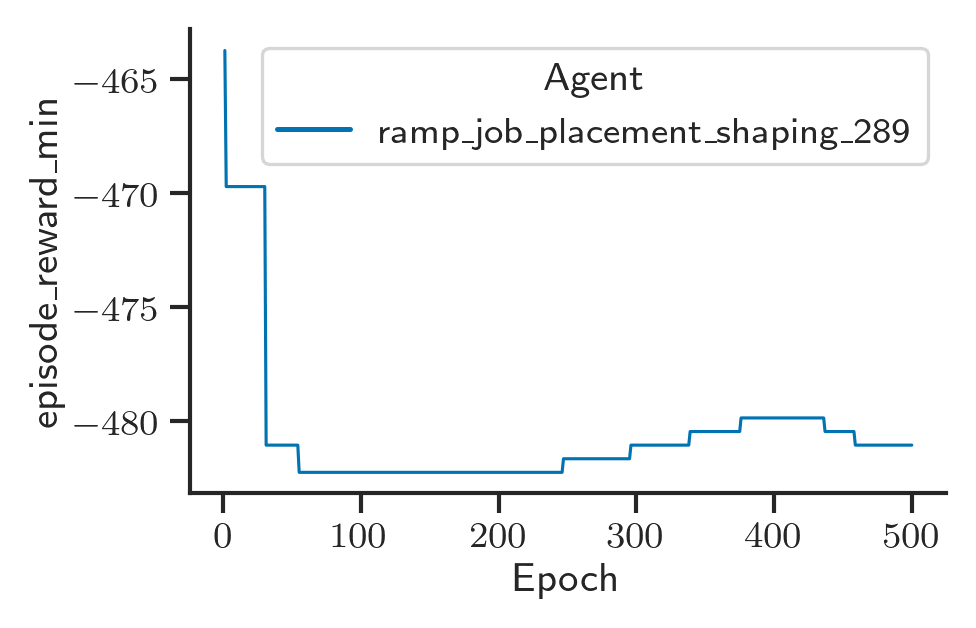

Plotting episode_reward_mean vs. Epoch...
Plotted episode_reward_mean vs. Epoch in 0.036 s.


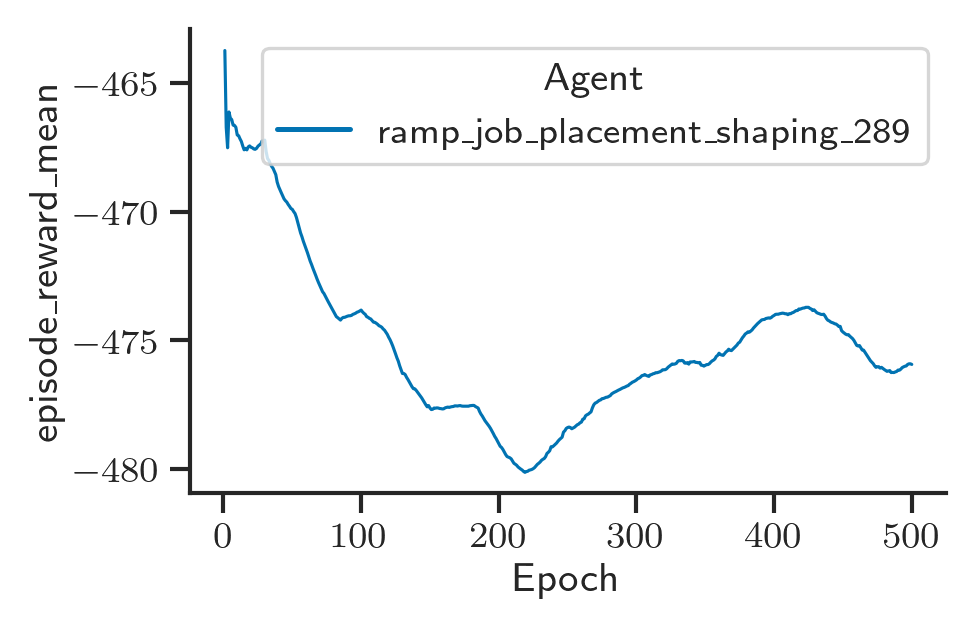

Plotting episode_reward_max vs. Epoch...
Plotted episode_reward_max vs. Epoch in 0.037 s.


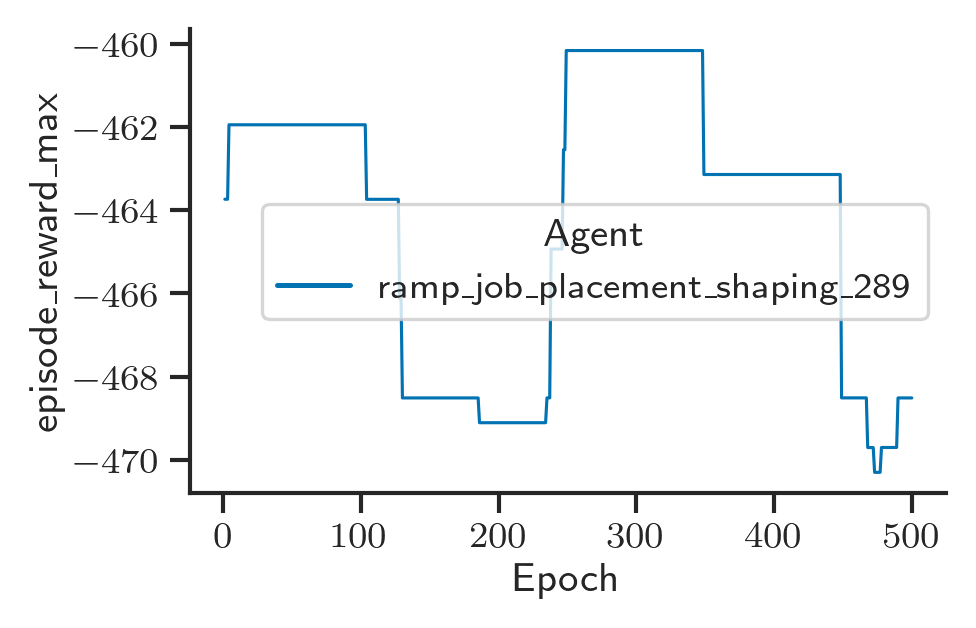

Plotting normalised_episode_reward_mean vs. Epoch...
Plotted normalised_episode_reward_mean vs. Epoch in 0.044 s.


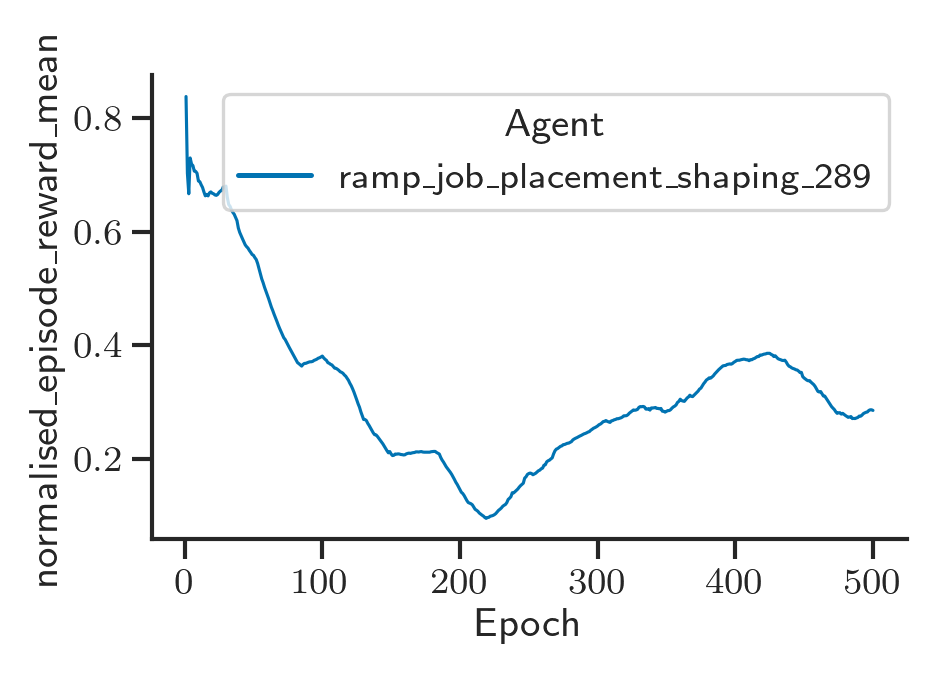

In [155]:
# RLLIB EPOCH ACTOR STATS
metrics_to_plot = {
                   'episode_reward_mean', 
                   'episode_reward_max', 
                   'episode_reward_min', 
                   'normalised_episode_reward_mean',
                  }
epochs_stats = defaultdict(lambda: [])
if 'rllib_results' in results:
    for agent, training_stats in results['rllib_results'].items():
        # print(training_stats)
        epochs_stats['Epoch'].extend(training_stats['training_iteration'])
        epochs_stats['Agent'].extend([agent for _ in range(len(training_stats['training_iteration']))])
        for metric in metrics_to_plot:
            if metric not in {'normalised_episode_reward_mean'}:
                epochs_stats[metric].extend(training_stats[metric])
        
        if 'normalised_episode_reward_mean' in metrics_to_plot:
            max_reward = np.amax(training_stats['episode_reward_max'])
            min_reward = np.amin(training_stats['episode_reward_min'])
            epochs_stats['normalised_episode_reward_mean'].extend([(abs(mean_reward - min_reward) / (abs(max_reward - min_reward))) for mean_reward in training_stats['episode_reward_mean']])
            
epochs_stats_df = pd.DataFrame(epochs_stats)
display(epochs_stats_df)

scaling_factor = 1
x = 'Epoch'
hue = 'Agent'
for metric in metrics_to_plot:
    print(f'Plotting {metric} vs. {x}...')
    start_time = time.time()
    fig = plot_line(epochs_stats_df, 
                    x=x, 
                    y=metric, 
                    hue=hue, 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
    print(f'Plotted {metric} vs. {x} in {time.time() - start_time:.3f} s.')
    plt.show()

In [156]:
# # RLLIB EPOCH ACTOR STATS WITH PER-STEP RESOLUTION
# metrics_to_plot = {'episode_reward', 'episode_lengths'}
# epochs_hist_stats = defaultdict(lambda: [])
# if 'rllib_results' in results:
#     for agent in results['rllib_results'].keys():
#         hist_stats = results['rllib_results'][agent]['hist_stats']
#         print(hist_stats)
#         for idx, epoch_hist_stats in enumerate(hist_stats):
#             for metric in metrics_to_plot:
#                 if metric not in {'normalised_episode_reward'}:
#                     for step_metric in epoch_hist_stats[metric]:
#                         epochs_hist_stats[metric].append(step_metric)
#             epochs_hist_stats['Agent'].extend([agent for _ in range(len(epoch_hist_stats[metric]))])
#             epochs_hist_stats['Epoch'].extend([results['rllib_results'][agent]['training_iteration'][idx] for _ in range(len(epoch_hist_stats[metric]))])
            
            
# epochs_hist_stats_df = pd.DataFrame(epochs_hist_stats)
# display(epochs_hist_stats_df)

# scaling_factor = 1
# x = 'Epoch'
# hue = 'Agent'
# for metric in metrics_to_plot:
#     print(f'Plotting {metric} vs. {x}...')
#     start_time = time.time()
#     fig = plot_line(epochs_hist_stats_df, 
#                     x=x, 
#                     y=metric, 
#                     hue=hue, 
#                     xlabel=x, 
#                     ylabel=metric, 
#                     err_style='band', # 'band' 'bars'
#                     ci=68, # 95 68
#                     scaling_factor=scaling_factor,
#                     show_fig=False)
#     print(f'Plotted {metric} vs. {x} in {time.time() - start_time:.3f} s.')
#     plt.show()

,mean_compute_throughput_mean,mean_num_mounted_workers_mean,job_communication_overhead_time_mean,job_completion_time_mean,job_computation_overhead_time_mean,mean_compute_overhead_frac_mean,mean_num_mounted_channels_mean,mean_comm_throughput_mean,mean_cluster_throughput_mean,mean_comm_overhead_frac_mean,Agent,Epoch
0,1.777879e+06,21.320000,18264.924094,18264.924094,18261.087724,1.000000,21.320000,2.466948e+06,4.244827e+06,0.999784,ramp_job_placement_shaping_289,0
1,1.649531e+06,19.780000,18264.191378,18264.191378,18260.673161,1.000000,19.780000,2.288855e+06,3.938386e+06,0.999805,ramp_job_placement_shaping_289,1
2,1.548368e+06,18.566667,18264.197814,18264.197814,18260.676802,0.996667,18.566667,2.148483e+06,3.696850e+06,0.996480,ramp_job_placement_shaping_289,2
3,1.622023e+06,19.450000,18264.391389,18264.391389,18260.786325,0.997500,19.450000,2.250686e+06,3.872709e+06,0.997310,ramp_job_placement_shaping_289,3
4,1.672627e+06,20.056000,18263.647859,18263.647859,18260.365644,0.998000,20.056000,2.320902e+06,3.993529e+06,0.997825,ramp_job_placement_shaping_289,4
...,...,...,...,...,...,...,...,...,...,...,...,...
495,8.368479e+05,10.037600,18269.027035,18269.027035,18263.409125,0.999900,10.037600,1.161193e+06,1.998040e+06,0.999590,ramp_job_placement_shaping_289,495
496,8.421495e+05,10.101200,18269.037968,18269.037968,18263.415311,0.999900,10.101200,1.168549e+06,2.010698e+06,0.999590,ramp_job_placement_shaping_289,496
497,8.435500e+05,10.118000,18269.037968,18269.037968,18263.415311,0.999900,10.118000,1.170492e+06,2.014042e+06,0.999590,ramp_job_placement_shaping_289,497
498,8.434833e+05,10.117200,18269.037968,18269.037968,18263.415311,0.999900,10.117200,1.170400e+06,2.013883e+06,0.999590,ramp_job_placement_shaping_289,498


Plotting mean_compute_throughput_mean vs. Epoch...
Plotted mean_compute_throughput_mean vs. Epoch in 0.043 s.


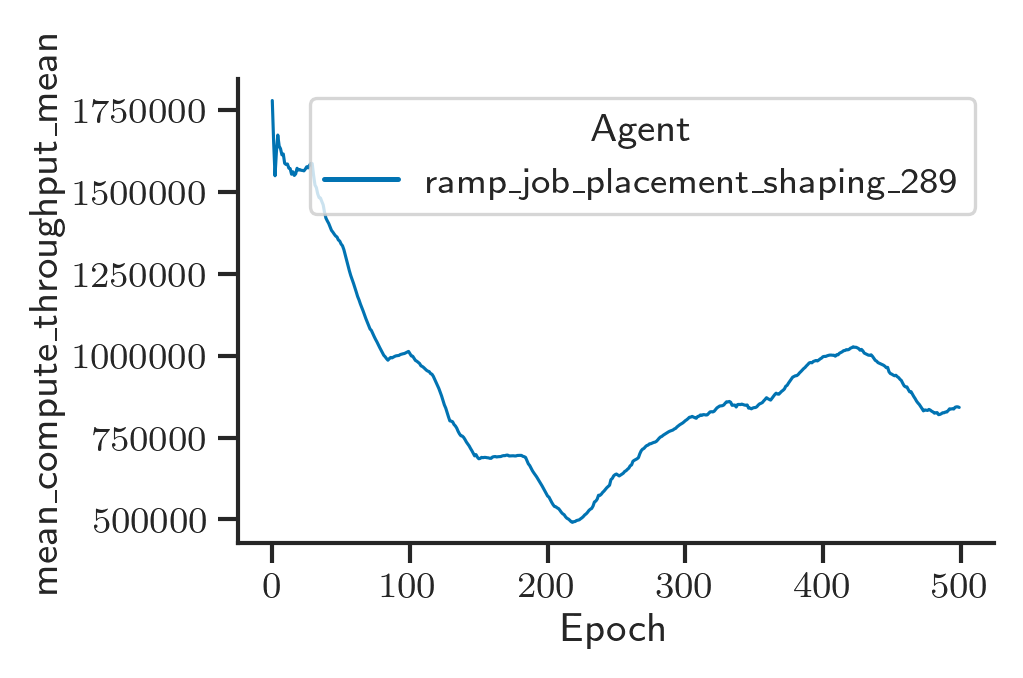

Plotting mean_num_mounted_workers_mean vs. Epoch...
Plotted mean_num_mounted_workers_mean vs. Epoch in 0.041 s.


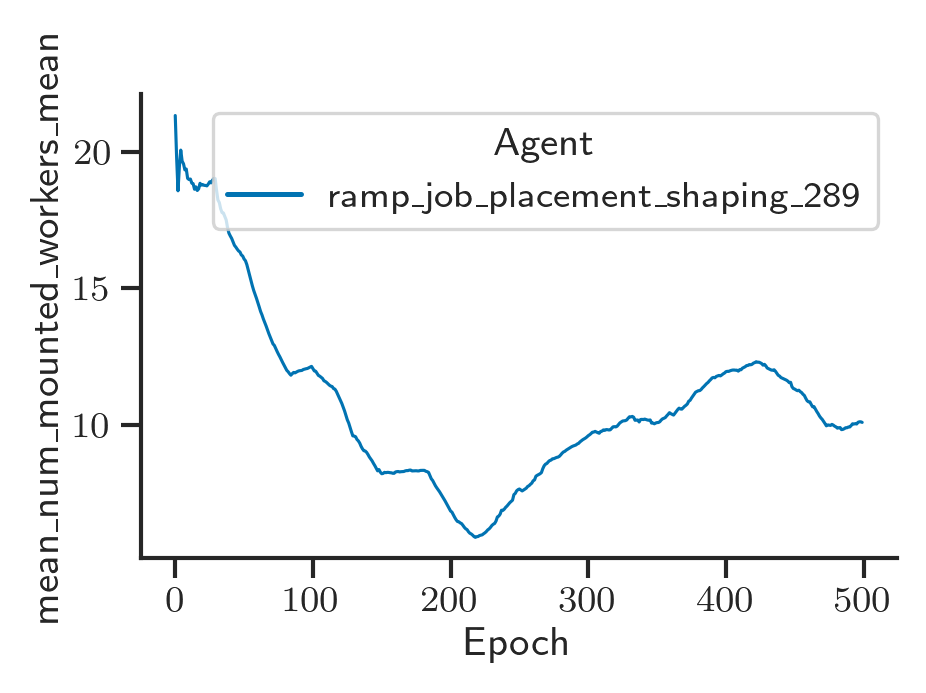

Plotting job_communication_overhead_time_mean vs. Epoch...
Plotted job_communication_overhead_time_mean vs. Epoch in 0.037 s.


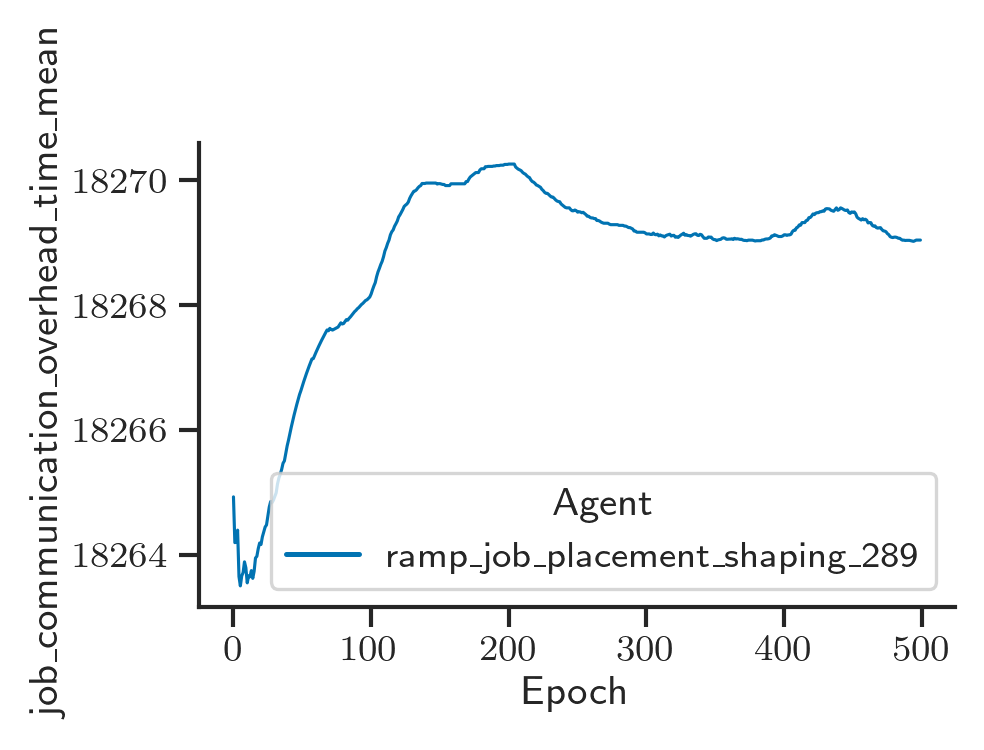

Plotting job_completion_time_mean vs. Epoch...
Plotted job_completion_time_mean vs. Epoch in 0.047 s.


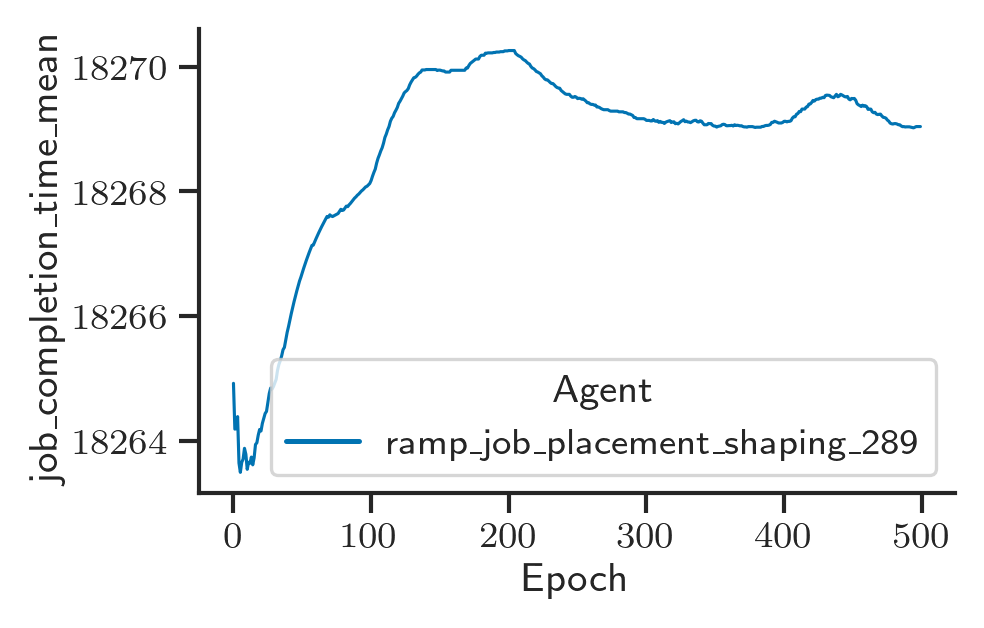

Plotting job_computation_overhead_time_mean vs. Epoch...
Plotted job_computation_overhead_time_mean vs. Epoch in 0.258 s.


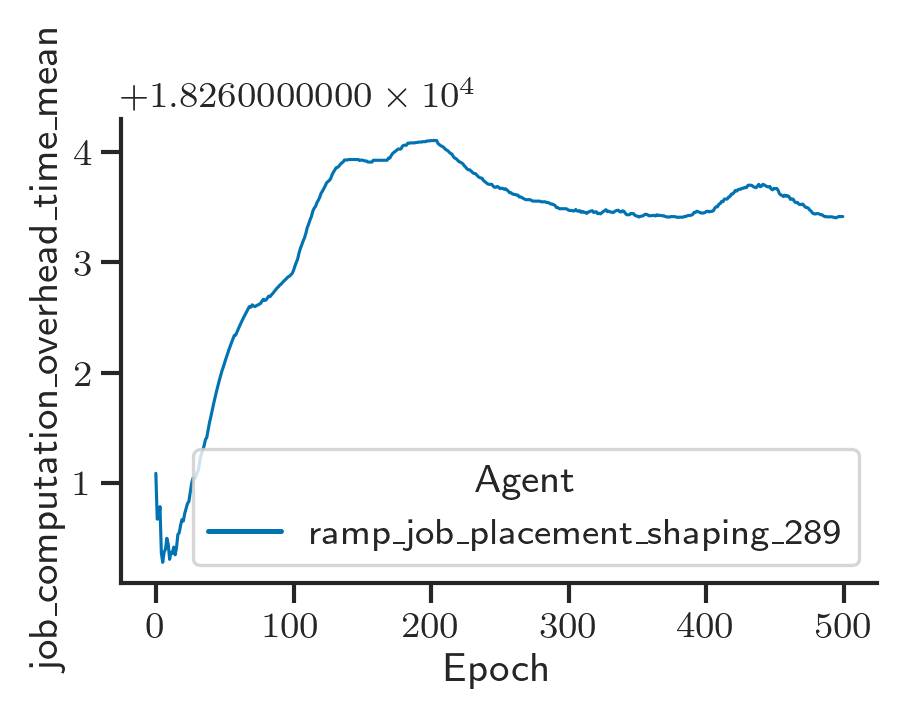

Plotting mean_compute_overhead_frac_mean vs. Epoch...
Plotted mean_compute_overhead_frac_mean vs. Epoch in 0.038 s.


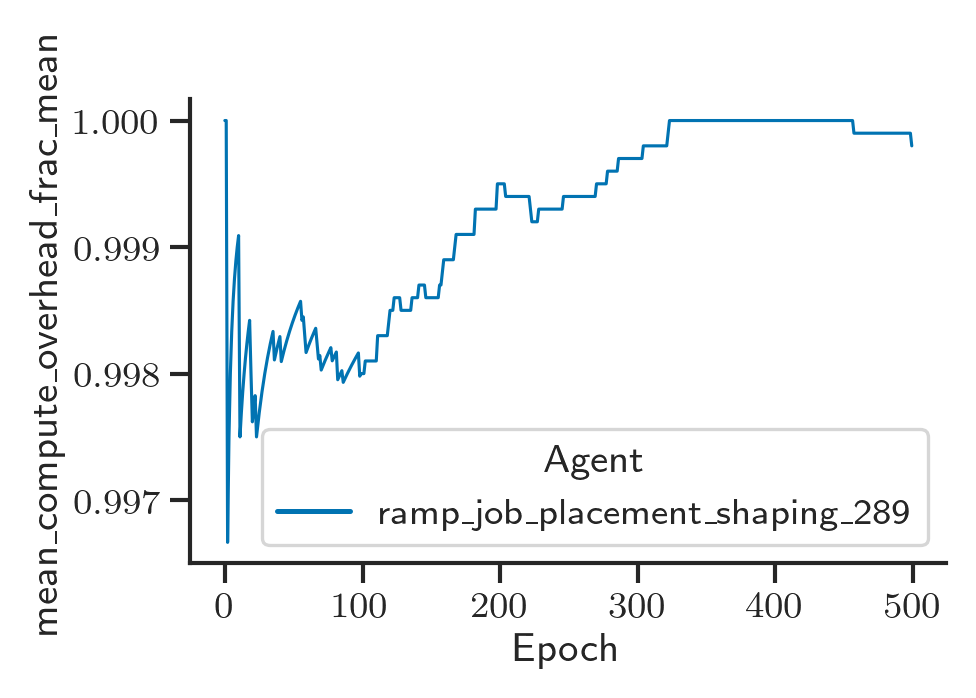

Plotting mean_num_mounted_channels_mean vs. Epoch...
Plotted mean_num_mounted_channels_mean vs. Epoch in 0.038 s.


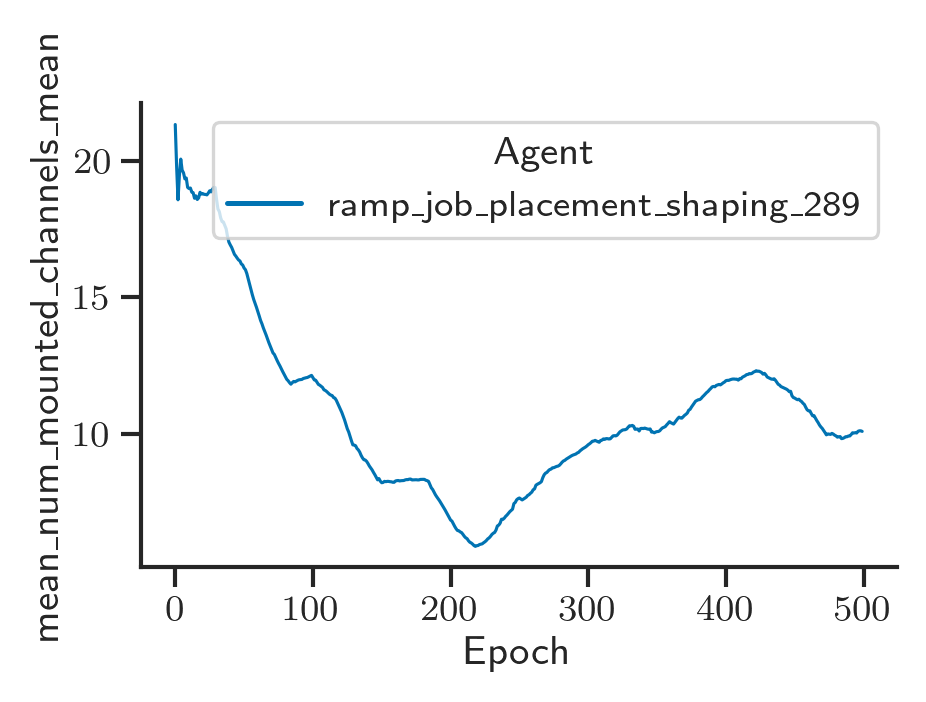

Plotting mean_comm_throughput_mean vs. Epoch...
Plotted mean_comm_throughput_mean vs. Epoch in 0.041 s.


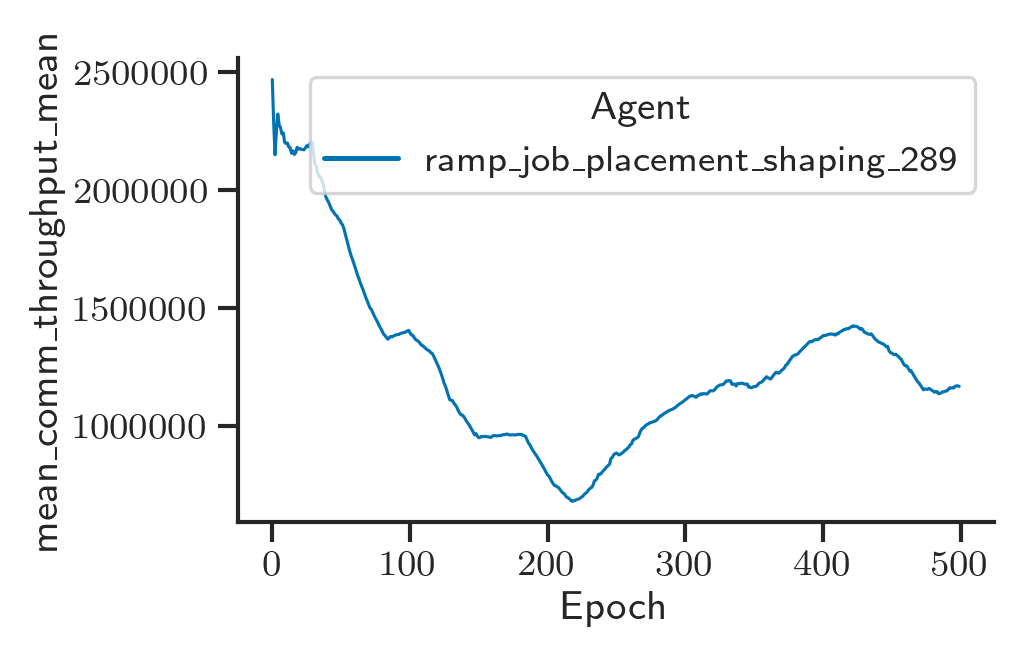

Plotting mean_cluster_throughput_mean vs. Epoch...
Plotted mean_cluster_throughput_mean vs. Epoch in 0.043 s.


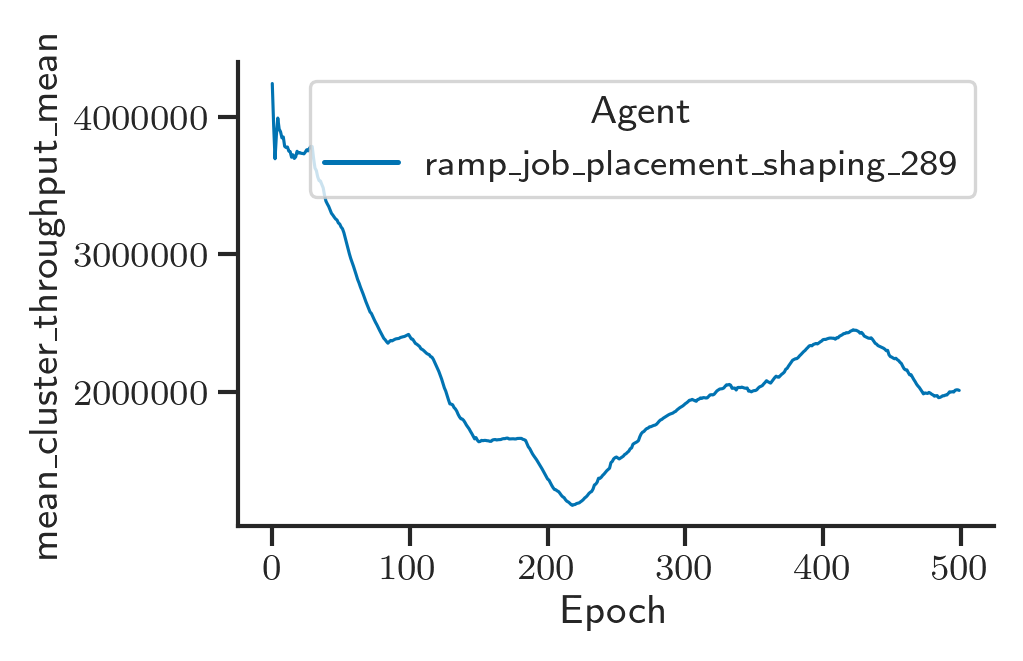

Plotting mean_comm_overhead_frac_mean vs. Epoch...
Plotted mean_comm_overhead_frac_mean vs. Epoch in 0.043 s.


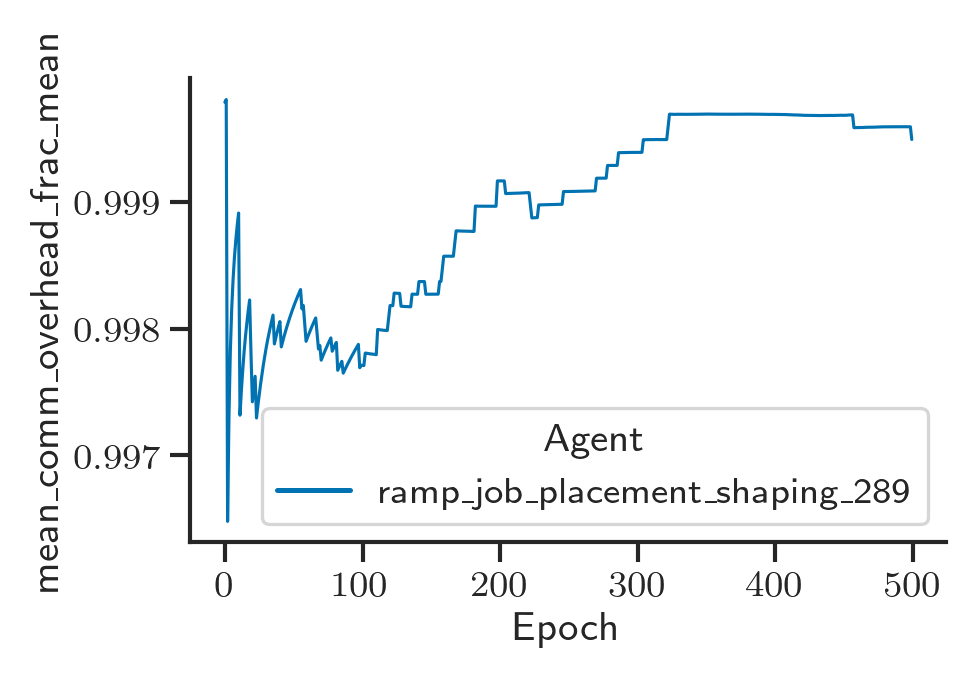

In [157]:
# RLLIB CUSTOM METRICS EPOCH ACTOR STATS
metrics_to_plot = {
                   'mean_num_mounted_workers_mean', 
                   'mean_num_mounted_channels_mean',
    
                   'mean_compute_throughput_mean',
                   'mean_comm_throughput_mean',
                   'mean_cluster_throughput_mean',
    
                   'mean_compute_overhead_frac_mean',
                   'mean_comm_overhead_frac_mean',
    
                   'job_completion_time_mean',
                   'job_communication_overhead_time_mean', 
                   'job_computation_overhead_time_mean',
                  }
epochs_stats = defaultdict(lambda: [])
if 'rllib_results' in results:
    for agent, training_stats in results['rllib_results'].items():
        # print(training_stats['custom_metrics'])
        for idx, epoch_hist_stats in enumerate(training_stats['custom_metrics']):
            # epochs_stats['Epoch'].extend(training_stats['training_iteration'])
            # epochs_stats['Agent'].extend([agent for _ in range(len(training_stats['training_iteration']))])
            # print(epoch_hist_stats)
            for metric in metrics_to_plot:
                if metric not in {'normalised_episode_reward_mean'}:
                    if metric in epoch_hist_stats:
                        epochs_stats[metric].append(epoch_hist_stats[metric])
                    else:
                        epochs_stats[metric].append(np.nan)
            epochs_stats['Agent'].append(agent)
            epochs_stats['Epoch'].append(idx)
                
epochs_stats_df = pd.DataFrame(epochs_stats)
display(epochs_stats_df)

scaling_factor = 1
x = 'Epoch'
hue = 'Agent'
for metric in metrics_to_plot:
    print(f'Plotting {metric} vs. {x}...')
    start_time = time.time()
    fig = plot_line(epochs_stats_df, 
                    x=x, 
                    y=metric, 
                    hue=hue, 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
    print(f'Plotted {metric} vs. {x} in {time.time() - start_time:.3f} s.')
    plt.show()

,cur_kl_coeff,cur_lr,total_loss,policy_loss,vf_loss,vf_explained_var,kl,entropy,entropy_coeff,Agent,Epoch
0,0.200000,0.00005,38651.683598,0.079401,38651.604354,0.000012,0.000007,2.721265,0.0,ramp_job_placement_shaping_289,1
1,0.100000,0.00005,39712.928685,0.077450,39712.851373,0.000014,0.000026,3.192119,0.0,ramp_job_placement_shaping_289,2
2,0.050000,0.00005,39459.666527,0.077089,39459.589516,0.000013,0.000031,3.287391,0.0,ramp_job_placement_shaping_289,3
3,0.025000,0.00005,38384.876855,0.076267,38384.800844,0.000006,0.000043,2.769807,0.0,ramp_job_placement_shaping_289,4
4,0.012500,0.00005,39422.101367,0.077799,39422.023683,-0.000006,0.000035,2.526457,0.0,ramp_job_placement_shaping_289,5
...,...,...,...,...,...,...,...,...,...,...,...
495,0.482553,0.00005,6534.706253,0.048062,6534.653838,-0.000252,0.009064,1.241601,0.0,ramp_job_placement_shaping_289,496
496,0.482553,0.00005,6419.825754,0.039080,6419.779110,-0.000588,0.015795,1.310125,0.0,ramp_job_placement_shaping_289,497
497,0.482553,0.00005,6467.053441,0.044608,6467.003645,-0.000418,0.010775,1.399794,0.0,ramp_job_placement_shaping_289,498
498,0.482553,0.00005,6507.890933,0.029800,6507.850742,-0.000305,0.021542,1.452967,0.0,ramp_job_placement_shaping_289,499


Plotting entropy vs. Epoch...
Plotted entropy vs. Epoch in 0.041 s.


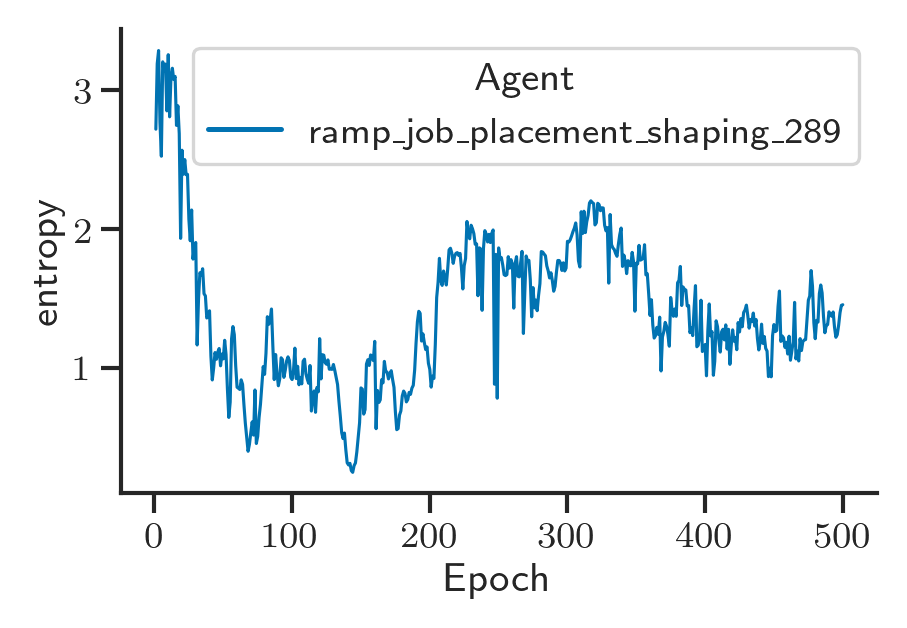

Plotting kl vs. Epoch...
Plotted kl vs. Epoch in 0.040 s.


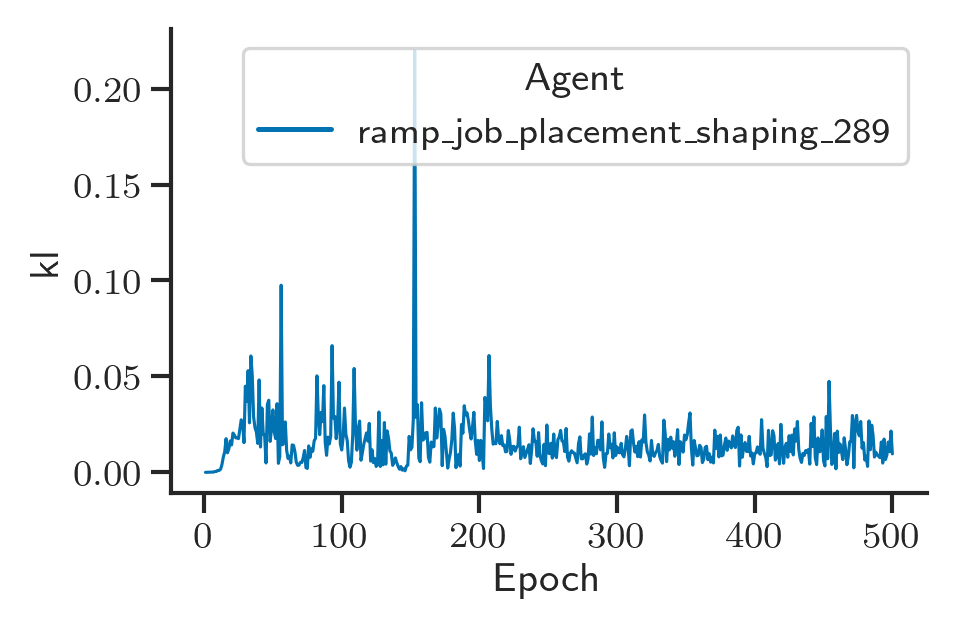

Plotting vf_loss vs. Epoch...
Plotted vf_loss vs. Epoch in 0.040 s.


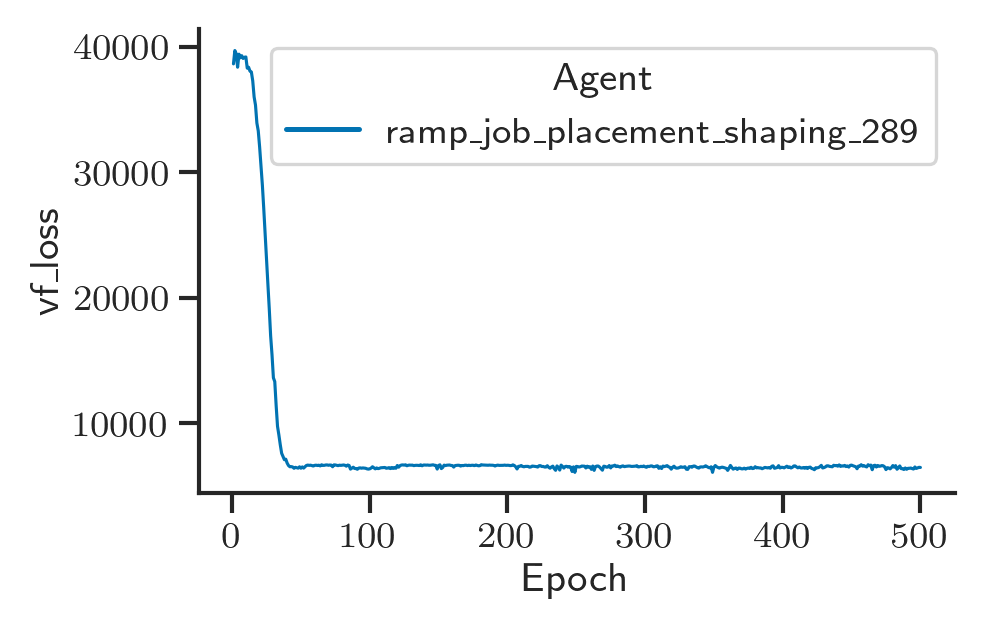

Plotting cur_kl_coeff vs. Epoch...
Plotted cur_kl_coeff vs. Epoch in 0.041 s.


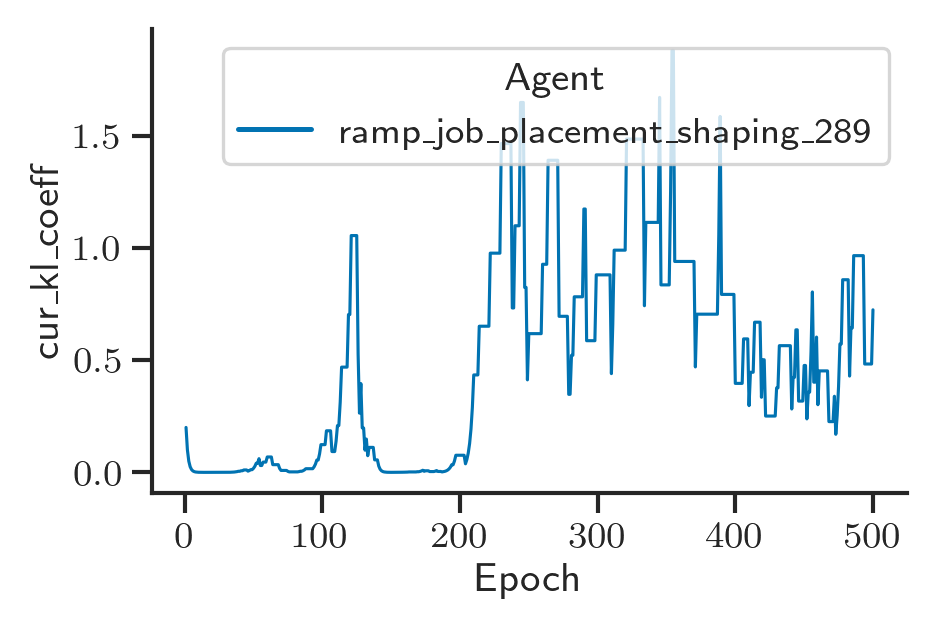

Plotting vf_explained_var vs. Epoch...
Plotted vf_explained_var vs. Epoch in 0.042 s.


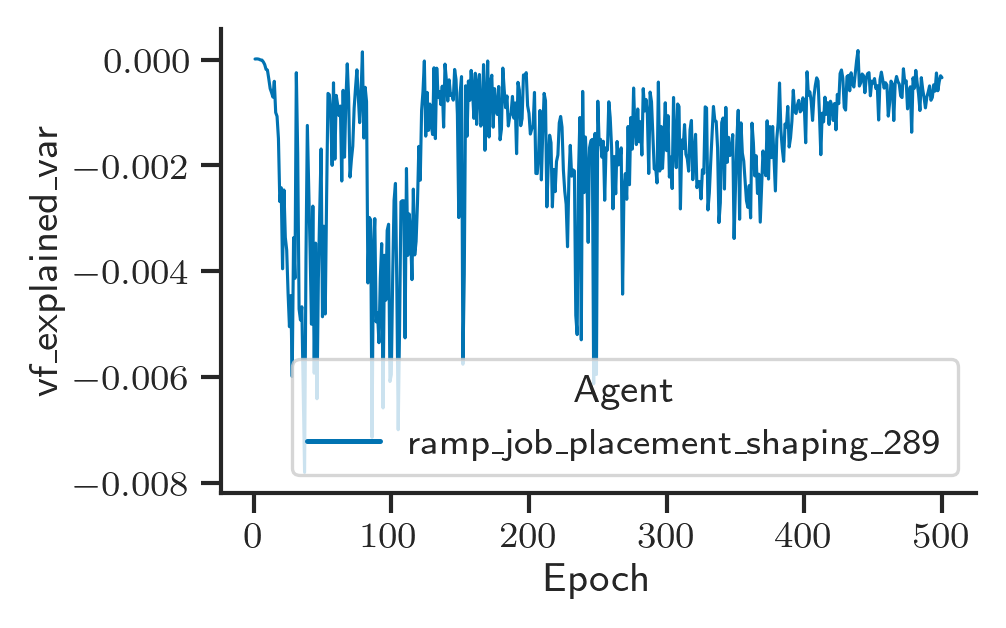

Plotting cur_lr vs. Epoch...
Plotted cur_lr vs. Epoch in 0.040 s.


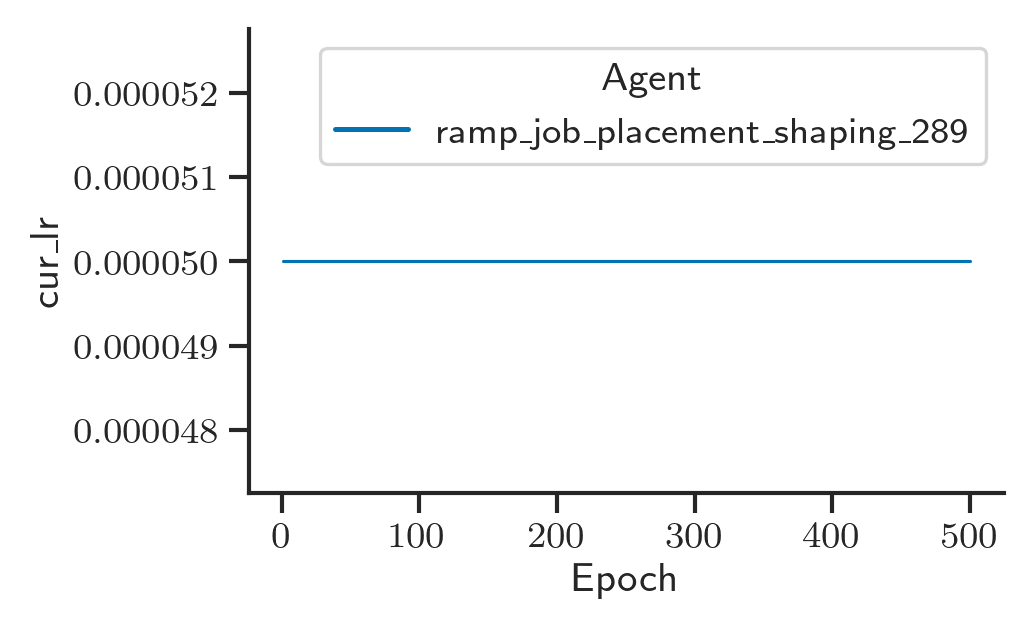

Plotting policy_loss vs. Epoch...
Plotted policy_loss vs. Epoch in 0.040 s.


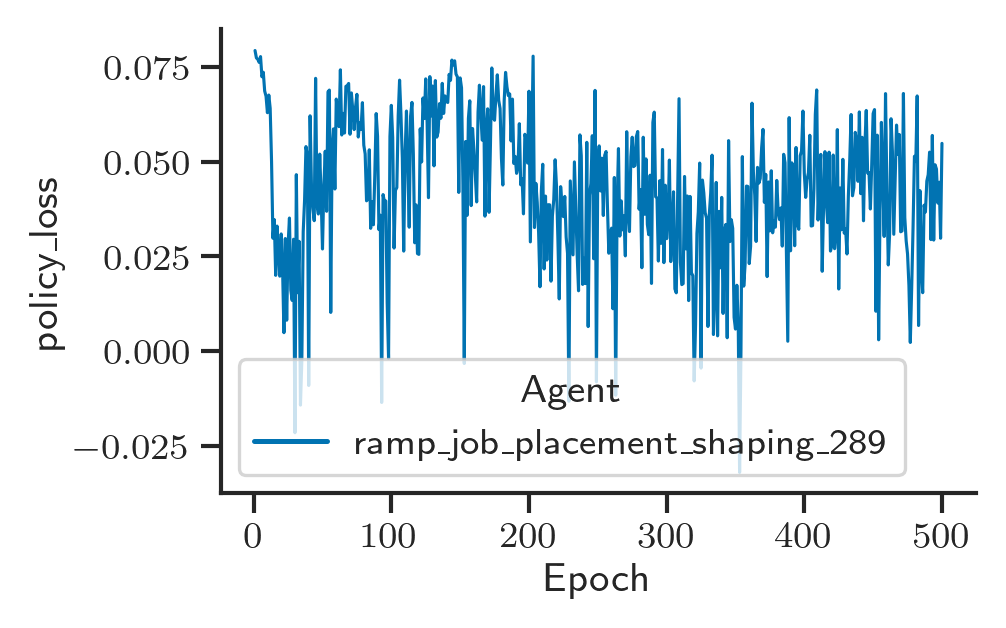

Plotting entropy_coeff vs. Epoch...
Plotted entropy_coeff vs. Epoch in 0.039 s.


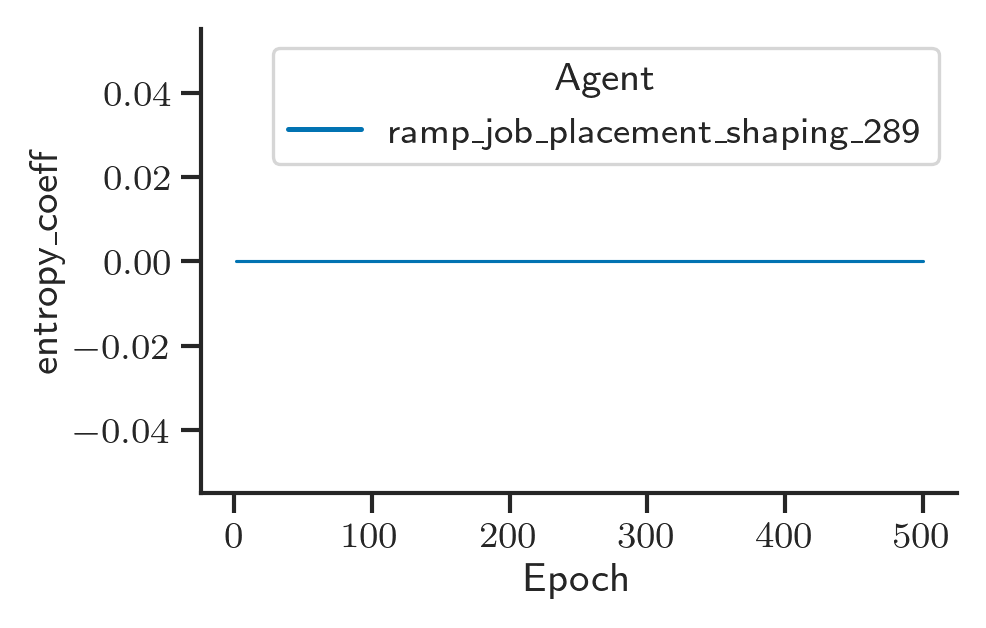

Plotting total_loss vs. Epoch...
Plotted total_loss vs. Epoch in 0.040 s.


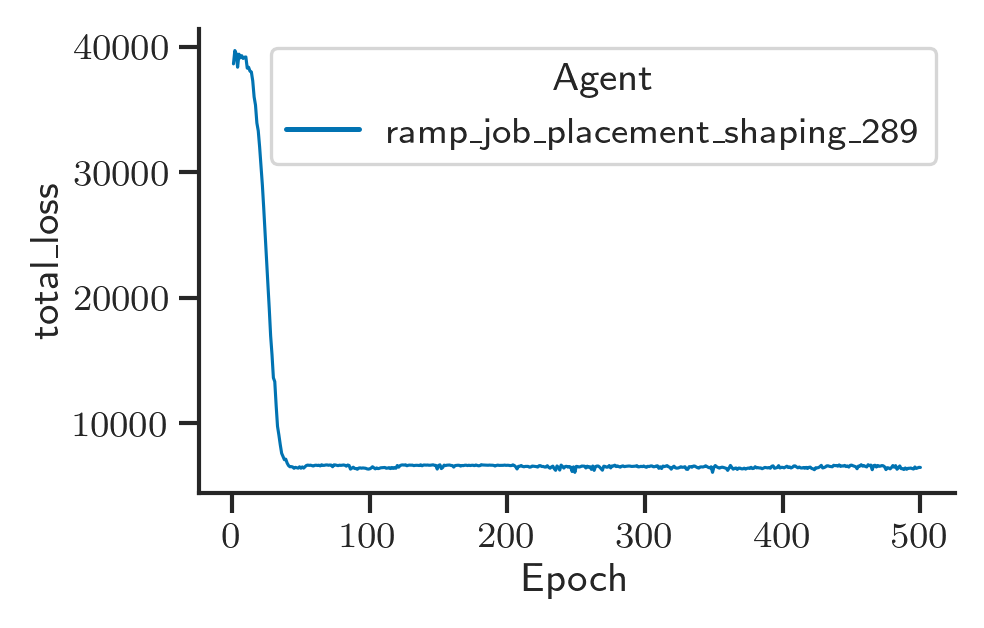

In [158]:
# RLLIB EPOCH LEARNER STATS
metrics_to_plot = set()
epochs_learner_stats = defaultdict(lambda: [])
if 'rllib_results' in results:
    for agent, training_stats in results['rllib_results'].items():
        epochs_stats['Epoch'].extend(training_stats['training_iteration'])
        epochs_stats['Agent'].extend([agent for _ in range(len(training_stats['training_iteration']))])
        
        info = results['rllib_results'][agent]['info']
        for idx, epoch_info in enumerate(info):
            for metric, stat in epoch_info['learner']['default_policy']['learner_stats'].items():
                metrics_to_plot.add(metric)
                epochs_learner_stats[metric].append(stat)
            epochs_learner_stats['Agent'].append(agent)
            epochs_learner_stats['Epoch'].append(results['rllib_results'][agent]['training_iteration'][idx])

            
epochs_learner_stats_df = pd.DataFrame(epochs_learner_stats)
display(epochs_learner_stats_df)

scaling_factor = 1
x = 'Epoch'
hue = 'Agent'
for metric in metrics_to_plot:
    print(f'Plotting {metric} vs. {x}...')
    start_time = time.time()
    fig = plot_line(epochs_learner_stats_df, 
                    x=x, 
                    y=metric, 
                    hue=hue, 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
    print(f'Plotted {metric} vs. {x} in {time.time() - start_time:.3f} s.')
    plt.show()